# **1. Install libraries**

In [ ]:
!pip install tensorflow  # Install TensorFlow using pip
!pip install transformers torch scikit-learn # Install required packages for transformers, torch, and scikit-learn
!pip install transformers[torch] # Install transformers with the torch dependency explicitly specified
!pip install accelerate -U # Update the accelerate package to the latest version
!pip install --upgrade scikit-learn # Upgrade scikit-learn to the latest version
!pip install sentencepiece # Install the sentencepiece library
!pip install spacy # Install the spaCy library
!pip install vaderSentiment # Install the vaderSentiment library
!python -m spacy download en_core_web_sm # Download the English language model for spaCy

# **2. Import dependancies**

In [ ]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time as tt
import warnings
import json
warnings.filterwarnings('ignore')

# Natural Language Processing (NLP) - NLTK and Gensim
import spacy
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Libraries - SKlearn
import sklearn.model_selection
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Transformers for NLP - Hugging Face Transformers and PyTorch
from transformers import get_scheduler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **3. Checking GPU availability**

In [ ]:
# Check if CUDA-enabled GPU is available for PyTorch computations
if torch.cuda.is_available():
    print('GPU available')
else:
    print('GPU not available')

GPU available


# **4. Functions**

In [ ]:
# Define text preprocessing function to remove regular expression, convert to lower string and removing stop words
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', "", text)
    text = text.lower()
    return ' '.join([word for word in text.split() if word not in stopwords.words('english')])

In [ ]:
# Function to train a transformer-based models
def model_train(model_name, num_epochs, batch_size):

    # Split data into training and testing sets
    train_size = 0.8
    train_df, test_df = train_test_split(df_train, test_size=1 - train_size, random_state=42)

    # Initialize the tokenizer and model based on the provided model_name
    if model_name == "distilbert":
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    elif model_name == "bert":
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    elif model_name == "roberta":
        tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    elif model_name == "deberta":
        tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
        model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2)  # Binary classification
    elif model_name == "xlnet":
        tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
        model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
    else:
        raise ValueError("Invalid model_name. Supported values: 'distilbert', 'bert', 'roberta', 'deberta','xlnet'")

    # Tokenize and prepare the data
    train_reviews = train_df['Review'].tolist()
    test_reviews = test_df['Review'].tolist()
    train_labels = train_df['overall_rating'].tolist()
    test_labels = test_df['overall_rating'].tolist()

    train_encodings = tokenizer(train_reviews, truncation=True, padding=True, return_tensors='pt')
    test_encodings = tokenizer(test_reviews, truncation=True, padding=True, return_tensors='pt')

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Set up the optimizer and training loop
    optimizer = AdamW(model.parameters(), lr=1e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=total_steps)

    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate scheduler

    model.eval()
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)
    confusion = confusion_matrix(true_labels, predicted_labels)

    print(f"{model_name} Model Evaluation:")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print(f"Accuracy: {accuracy}")
    print("Classification report:")
    print(report)
    print("Confusion Matrix:")
    print(pd.DataFrame(confusion, columns=["Predicted Negative", "Predicted Positive"], index=["True Negative", "True Positive"]))

    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return model, tokenizer

# **5. Load the dataset**

In [ ]:
# Mount the Google Drive to the Colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/MSc Greenwich/MSc Project/Project/Glassdoor/glassdoor_reviews.csv'

In [ ]:
glassdoor_data = pd.read_csv(file_path)

In [ ]:
glassdoor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838566 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 838566 non-null  object 
 1   date_review          838566 non-null  object 
 2   job_title            838566 non-null  object 
 3   current              838566 non-null  object 
 4   location             541228 non-null  object 
 5   overall_rating       838566 non-null  int64  
 6   work_life_balance    688672 non-null  float64
 7   culture_values       647193 non-null  float64
 8   diversity_inclusion  136066 non-null  float64
 9   career_opp           691065 non-null  float64
 10  comp_benefits        688484 non-null  float64
 11  senior_mgmt          682690 non-null  float64
 12  recommend            838566 non-null  object 
 13  ceo_approv           838566 non-null  object 
 14  outlook              838566 non-null  object 
 15  headline         

In [ ]:
glassdoor_data.shape

(838566, 18)

In [ ]:

glassdoor_data.head(1)

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."


In [ ]:
# Finding the number of unique values extracted from the 'firm' column
no_jobs = glassdoor_data['firm'].unique()
len(no_jobs)

428

In [ ]:
# Display the resulting top 30 firms/companies with their review counts
jobs_by_reviews = glassdoor_data['firm'].value_counts()
j1 = jobs_by_reviews[:30]
j1

IBM                       60436
McDonald-s                49450
Deloitte                  46995
EY                        34050
PwC                       33227
Oracle                    31941
Microsoft                 26675
J-P-Morgan                25814
KPMG                      24815
Apple                     20797
Citi                      18726
Google                    15995
SAP                       14344
HSBC-Holdings             13893
Tesco                     12149
Marriott-International    10409
Barclays                   9710
Thomson-Reuters            9553
American-Express           9349
Morgan-Stanley             9093
Goldman-Sachs              8808
Vodafone                   8321
Salesforce                 8234
Pizza-Hut                  7592
BNY-Mellon                 6630
Deutsche-Bank              6388
Hilton                     6155
J-Sainsbury                5925
GlaxoSmithKline            5646
Unilever                   5632
Name: firm, dtype: int64

In [ ]:
# Check for null values in the 'glassdoor_data' DataFrame and calculate the sum of null values for each column
glassdoor_data.isnull().sum()

firm                        0
date_review                 0
job_title                   0
current                     0
location               297338
overall_rating              0
work_life_balance      149894
culture_values         191373
diversity_inclusion    702500
career_opp             147501
comp_benefits          150082
senior_mgmt            155876
recommend                   0
ceo_approv                  0
outlook                     0
headline                 2219
pros                        0
cons                        8
dtype: int64

In [ ]:
# Create a random subset of the main dataset
subset_fraction = 0.05
glassdoor_data_sample = glassdoor_data.sample(frac=subset_fraction, random_state=42)

In [ ]:
# Count the occurrences of each unique value (company) in the 'firm' column of the 'glassdoor_data_sample' DataFrame
jobs_by_reviews_sample = glassdoor_data_sample['firm'].value_counts()
j2 = jobs_by_reviews_sample[:30]
print(f'Number of UK companies in the sample is: {len(glassdoor_data_sample["firm"].unique())}')

Number of UK companies in the sample is: 409


In [ ]:
# Drop columns not required for analysis
Notkeep = [d for d in glassdoor_data_sample.columns if d not in ['overall_rating','headline','pros','cons','firm','date_review']]
glassdoor_data_sample    = glassdoor_data_sample.drop(columns=Notkeep)
glassdoor_data_sample['date_review'] = pd.to_datetime(glassdoor_data_sample['date_review'])

# Get column names for each types
types_str = glassdoor_data_sample.select_dtypes(include='object').columns
types_int = glassdoor_data_sample.select_dtypes(include=[int,float]).columns

# Drop Duplicates
duplicate = glassdoor_data_sample[['headline','pros','cons']].duplicated()
glassdoor_data_sample = glassdoor_data_sample.loc[duplicate==False]
glassdoor_data_sample = glassdoor_data_sample.reset_index()
print('Drop Duplicated:',duplicate.sum())

# Final frame
cols = ['overall_rating','headline','pros','cons','date_review']
df = glassdoor_data_sample[cols]

Drop Duplicated: 76


In [ ]:
df.shape

(41852, 5)

In [ ]:
df.isnull().sum()

overall_rating      0
headline          121
pros                0
cons                1
date_review         0
dtype: int64

In [ ]:
# Drop the rows that are having nullvalues
df = df.dropna(subset=['headline','cons'])
df.shape

(41730, 5)

In [ ]:
# Sample size and train percent
sample_size = 10000
train_percent = 0.7

# Take a random sample from the main dataset
sampled_data = df.sample(n=sample_size, random_state=42)

# Perform train-test split while maintaining the 'overall_rating' distribution
df_train, df_test = train_test_split(sampled_data, train_size=train_percent, stratify=sampled_data['overall_rating'], random_state=42)

# Check the 'overall_rating' distribution in train and test sets
print("Train set 'overall_rating' distribution:")
print(df_train['overall_rating'].value_counts(normalize=True))

print("\nTest set 'overall_rating' distribution:")
print(df_test['overall_rating'].value_counts(normalize=True))

Train set 'overall_rating' distribution:
4    0.334714
5    0.277286
3    0.228571
2    0.086286
1    0.073143
Name: overall_rating, dtype: float64

Test set 'overall_rating' distribution:
4    0.334667
5    0.277000
3    0.228667
2    0.086333
1    0.073333
Name: overall_rating, dtype: float64


In [ ]:
print(f'Length of train data: {len(df_train)}')
print(f'Length of development data: {len(df_test)}')

Length of train data: 7000
Length of development data: 3000


In [ ]:
df_train.head(1)

,overall_rating,headline,pros,cons,date_review
18881,2,"Patent ""center of excellence"" is a JOKE!","Relaxed, laid back atmosphere to work\r\nPlent...","Focus entirely on Quantity, not Quality or Com...",2015-06-16


In [ ]:
#print(df_train['headline'][0])
print(df_train['headline'].iloc[0])

Patent "center of excellence" is a JOKE!


In [ ]:
print(df_train['pros'].iloc[0])

Relaxed, laid back atmosphere to work
Plenty of walking around and chatting
Opportunity to learn IF you have the right team leader and cultivate a friendship with the top manager


In [ ]:
print(df_train['cons'].iloc[0])

Focus entirely on Quantity, not Quality or Complexity of work submitted
Nepotism runs rampant
No incentive to do good work, just churn it out to be rewarded
No opportunity for advancement - nobody wants to help you move up since that would leave them with finding a replacement and Rochester is not a great attraction
Pay is roughly 40% below of market rates - just for those with a BS degree, around 50-60% below market if you have a JD or USPTO registration;
I left and was offered 2x my last salary when I inquired about returning.


In [ ]:
df_train.loc[:, 'Review'] = df_train['headline'] + " " + df_train['pros'] + " " + df_train['cons']

In [ ]:
print(df_train['Review'].iloc[0])

Patent "center of excellence" is a JOKE! Relaxed, laid back atmosphere to work
Plenty of walking around and chatting
Opportunity to learn IF you have the right team leader and cultivate a friendship with the top manager Focus entirely on Quantity, not Quality or Complexity of work submitted
Nepotism runs rampant
No incentive to do good work, just churn it out to be rewarded
No opportunity for advancement - nobody wants to help you move up since that would leave them with finding a replacement and Rochester is not a great attraction
Pay is roughly 40% below of market rates - just for those with a BS degree, around 50-60% below market if you have a JD or USPTO registration;
I left and was offered 2x my last salary when I inquired about returning.


In [ ]:
df_train['overall_rating'].value_counts()

4    2343
5    1941
3    1600
2     604
1     512
Name: overall_rating, dtype: int64

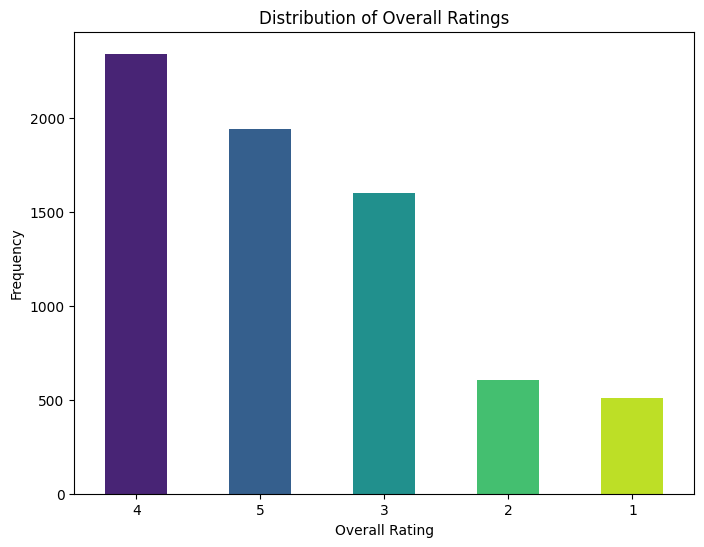

In [ ]:
# Create a bar chart
colors = sns.color_palette("crest", 5)
colors = plt.cm.viridis_r([0.9, 0.7, 0.5, 0.3, 0.1])
plt.figure(figsize=(8, 6))
df_train['overall_rating'].value_counts().plot(kind='bar', color=colors)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.yticks()
plt.show()

# **6. Text Preprocessing**

## **6.1 Average Rating**

In [ ]:
average_rating = df_train['overall_rating'].mean()
print(f'{average_rating:.2f}')

3.66


In [ ]:
print(f'Mode:{df_train.overall_rating.mode()}')

Mode:0    4
Name: overall_rating, dtype: int64


In [ ]:
print(df_train.duplicated().sum())

0


In [ ]:
df_train = df_train.drop_duplicates()

## **6.2 Re-map the target values**

Binary (Positive/Negative) Sentiment Analysis:

In [ ]:
df_train['overall_rating'] = df_train['overall_rating'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
df_train['overall_rating'].value_counts()

1    4284
0    2716
Name: overall_rating, dtype: int64

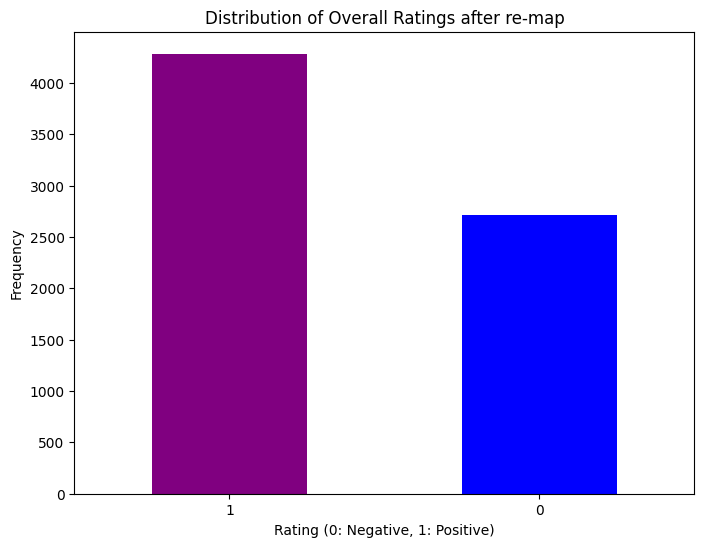

In [ ]:
plt.figure(figsize=(8, 6))
df_train['overall_rating'].value_counts().plot(kind='bar', color= ['purple','blue'])
plt.title('Distribution of Overall Ratings after re-map')
plt.xlabel('Rating (0: Negative, 1: Positive)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.yticks()
plt.show()

In [ ]:
# Preprocess the 'Review' column
df_train['Review']= df_train['Review'].apply(preprocess_text)

In [ ]:
df_train['Review'].iloc[0]

'patent center excellence joke relaxed laid back atmosphere work plenty walking around chatting opportunity learn right team leader cultivate friendship top manager focus entirely quantity quality complexity work submitted nepotism runs rampant incentive good work churn rewarded opportunity advancement nobody wants help move since would leave finding replacement rochester great attraction pay roughly 40 market rates bs degree around 5060 market jd uspto registration left offered 2x last salary inquired returning'

## **6.3 Torkenize the data**

In [ ]:
def text_preprocessing_2(data):
  comments = data['Review']
  labels = data['overall_rating']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)
  return comments_splitted, labels

In [ ]:
comments_splitted, labels = text_preprocessing_2(df_train)

In [ ]:
comments_splitted[0]



---



In [ ]:
tokenized_comments = [word_tokenize(comment) for comment in df_train['Review']]

In [ ]:
tokenized_comments = []
for comment in df_train['Review']:
    tokenized_comment = word_tokenize(comment)
    tokenized_comments.append(tokenized_comment)

In [ ]:
tokenized_comments[0]

In [ ]:
df_train.shape

(7000, 6)

## **6.4 Lemmatize the data**

In [ ]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the tokenized comments
lemmatized_comments = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in tokenized_comments]

In [ ]:
lemmatized_comments[0]

# **7.  Word Embedding**

## **7.1 Generate Embedding Matrix**

Train Word2Vec *Model*

In [ ]:
# Train Word2Vec model
word2vec_model  = Word2Vec(sentences=lemmatized_comments, vector_size=100, window=5, min_count=1, sg=0)

# Save the trained Word2Vec model
word2vec_model.save("word2vec_model")

## **7.2 Load Embedding Matrix**

In [ ]:
# Load the saved Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model")

## **7.3 Vectorize Data Using Word2Vec**

In [ ]:
# Function to vectorize text using Word2Vec
def vectorize_text(review, word2vec_model):
    vectors = [word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Apply vectorization to 'Review' column
df_train['Vectorized_Review'] = df_train['Review'].apply(lambda x: vectorize_text(x, word2vec_model))
df_train['Vectorized_Review'] = df_train['Vectorized_Review'].apply(lambda x: x.astype('float32'))

In [ ]:
df_train.head(3)

,overall_rating,headline,pros,cons,date_review,Review,Vectorized_Review
18881,0,"Patent ""center of excellence"" is a JOKE!","Relaxed, laid back atmosphere to work\r\nPlent...","Focus entirely on Quantity, not Quality or Com...",2015-06-16,patent center excellence joke relaxed laid bac...,"[0.051537655, 0.34658515, -0.064443246, 0.1144..."
4612,0,Great company if you're on a well managed project,Some of the most talented people I've ever had...,Not all management was as good in all studio g...,2016-04-08,great company youre well managed project talen...,"[0.025398687, 0.36319637, -0.037851952, 0.0499..."
33442,1,OK Place to Work,Decent pay for part time student,Lack of shift flexibility - despite prior noti...,2021-05-20,ok place work decent pay part time student lac...,"[0.12969516, 0.4415266, -0.08974507, 0.2384462..."


# **8. Model Training and Evaluation**

In [ ]:
# Split data into training and testing sets
train_size = 0.8
train_df, test_df = train_test_split(df_train, test_size= 1 - train_size, random_state=42)

## **8.1 DistilBERT**

In [ ]:
# Initialise the model parameters
model_name = "distilbert"
num_epochs = 10
batch_size = 8

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


distilbert Model Evaluation:
Balanced Accuracy: 0.7255510562500136
Accuracy: 0.7571428571428571
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       527
           1       0.78      0.85      0.81       873

    accuracy                           0.76      1400
   macro avg       0.74      0.73      0.73      1400
weighted avg       0.75      0.76      0.75      1400

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 315                 212
True Positive                 128                 745


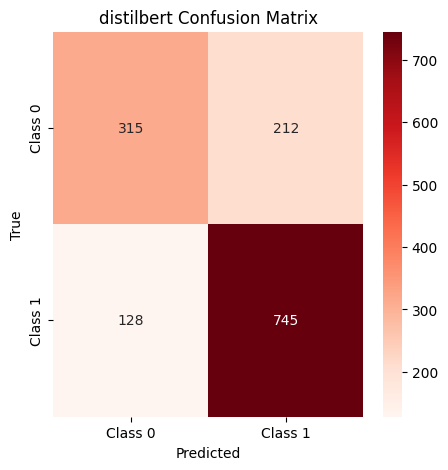

distilbert model training took 160.96 seconds.


In [ ]:
# Train the model
start_time = tt.time()
distilbert_model, distilbert_tokenizer = model_train(model_name, num_epochs, batch_size)
end_time = tt.time()
training_duration = end_time - start_time
print(f"{model_name} model training took {training_duration:.2f} seconds.")

## **8.2 BERT**

In [ ]:
model_name = "bert"
num_epochs = 10
batch_size = 8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert Model Evaluation:
Balanced Accuracy: 0.7210734864836079
Accuracy: 0.76
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       527
           1       0.77      0.88      0.82       873

    accuracy                           0.76      1400
   macro avg       0.75      0.72      0.73      1400
weighted avg       0.76      0.76      0.75      1400

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 297                 230
True Positive                 106                 767


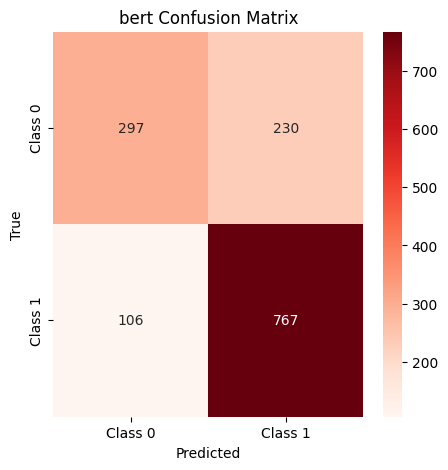

bert model training took 307.12 seconds.


In [ ]:
# Train the model
start_time = tt.time()
bert_model, bert_tokenizer = model_train(model_name, num_epochs, batch_size)
end_time = tt.time()
training_duration = end_time - start_time
print(f"{model_name} model training took {training_duration:.2f} seconds.")

## **8.3 RoBERTa**

In [ ]:
model_name = "roberta"
num_epochs = 10
batch_size = 8

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta Model Evaluation:
Balanced Accuracy: 0.7275007553182009
Accuracy: 0.7628571428571429
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       527
           1       0.78      0.87      0.82       873

    accuracy                           0.76      1400
   macro avg       0.75      0.73      0.74      1400
weighted avg       0.76      0.76      0.76      1400

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 308                 219
True Positive                 113                 760


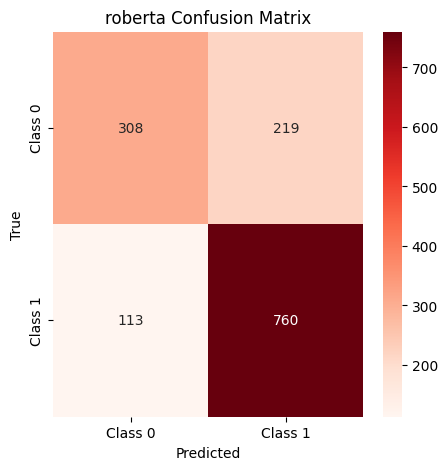

roberta model training took 306.22 seconds.


In [ ]:
# Train the model
start_time = tt.time()
roberta_model, roberta_tokenizer = model_train(model_name, num_epochs, batch_size)
end_time = tt.time()
training_duration = end_time - start_time
print(f"{model_name} model training took {training_duration:.2f} seconds.")

## **8.4 DeBERTa**

In [ ]:
model_name = "deberta"
num_epochs = 10
batch_size = 8

In [ ]:
!git clone https://github.com/microsoft/DeBERTa.git

fatal: destination path 'DeBERTa' already exists and is not an empty directory.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


deberta Model Evaluation:
Balanced Accuracy: 0.7282528131527526
Accuracy: 0.7628571428571429
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       527
           1       0.78      0.87      0.82       873

    accuracy                           0.76      1400
   macro avg       0.75      0.73      0.74      1400
weighted avg       0.76      0.76      0.76      1400

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 310                 217
True Positive                 115                 758


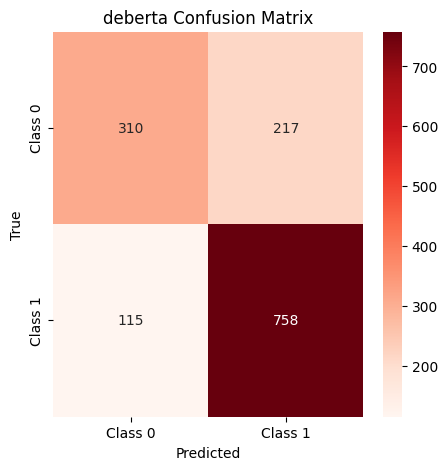

deberta model training took 495.25 seconds.


In [ ]:
# Train the model
start_time = tt.time()
deberta_model, deberta_tokenizer = model_train(model_name, num_epochs, batch_size)
end_time = tt.time()
training_duration = end_time - start_time
print(f"{model_name} model training took {training_duration:.2f} seconds.")

## **8.5 XLNet**

In [ ]:
model_name = "xlnet"
num_epochs = 10
batch_size = 8

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


xlnet Model Evaluation:
Balanced Accuracy: 0.7273388237902411
Accuracy: 0.765
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.57      0.65       527
           1       0.77      0.88      0.82       873

    accuracy                           0.77      1400
   macro avg       0.76      0.73      0.74      1400
weighted avg       0.76      0.77      0.76      1400

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 303                 224
True Positive                 105                 768


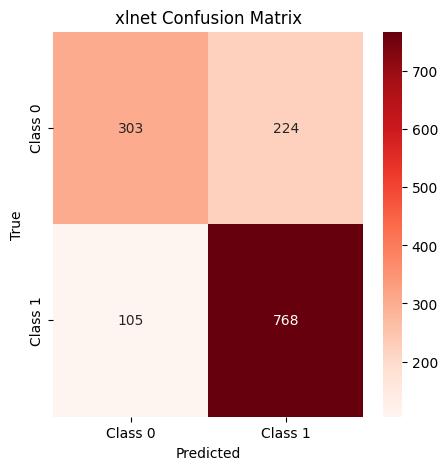

xlnet model training took 671.54 seconds.


In [ ]:
# Train the model
start_time = tt.time()
xlnet_model, xlnet_tokenizer = model_train(model_name, num_epochs, batch_size)
end_time = tt.time()
training_duration = end_time - start_time
print(f"{model_name} model training took {training_duration:.2f} seconds.")

## **9.1 Save the model**

A PyTorch model is typically stored in a binary format.

In [ ]:
# Save the state dictionary (trained weights) of the XLNet model to a file named 'xlnet_model.pth'
torch.save(xlnet_model.state_dict(), 'xlnet_model.pth')

# Save XLNet tokenizer's configuration and vocabulary to the directory 'xlnet_tokenizer'
xlnet_tokenizer.save_pretrained('xlnet_tokenizer')

('xlnet_tokenizer/tokenizer_config.json',
 'xlnet_tokenizer/special_tokens_map.json',
 'xlnet_tokenizer/spiece.model',
 'xlnet_tokenizer/added_tokens.json')

In [ ]:
# Additional meta data are saved in a JSON file

metadata = {
    'model_name': 'XLnet',
    'num_labels': 2,
    'training_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': 1e-5,
}

# Save metadata to a JSON file
with open('model_metadata.json', 'w') as json_file:
    json.dump(metadata, json_file)


## **9.2 Load model**

In [ ]:
# Load the model
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
model.load_state_dict(torch.load('xlnet_model.pth'))
torkenizer = XLNetTokenizer.from_pretrained('xlnet_tokenizer')

# Load metadata from JSON
with open('model_metadata.json', 'r') as json_file:
    metadata = json.load(json_file)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **10. Use the model to predict unseen data**

In [ ]:
df_test

,overall_rating,headline,pros,cons,date_review
32684,5,Nice,Nice mice and men and women who,Mice and rats were not available,2020-07-08
2880,4,Software Engineer,Flexible hours\r\nagile technology\r\nFusion t...,Can't think of anything right now,2016-06-25
33214,4,Was great,Good working environment and colleagues,Sales targets were a little pressurising somet...,2020-12-18
2389,5,it makes ur CV a brand when u get to work for ...,worth-it working for the company.,might loose track of family time.,2017-07-01
8715,5,Department Manager,I joined Sytner 4 years ago and haven't looked...,None - unless you are afraid of working hard a...,2018-05-25
...,...,...,...,...,...
19489,4,"Flexible schedule, nice working environment",Flexible schedule that allows you to work on y...,Can be stressful sometimes because of the work...,2014-10-17
10021,3,Experience,Good work environment. Opportunities for growth.,Low Compensation. Not a good training infrastr...,2017-01-01
4109,4,Decent place to work and jump start your caree...,Pretty entrepreneurial in that the company let...,Not enough synergies within the organization. ...,2014-02-14
14920,4,Great place to start your career,"Great learning opportunity, professional & fri...",Very heavy workload & unfair rewards\r\nPoor w...,2016-05-15


In [ ]:
# Concatenate columns 'headline', 'pros', and 'cons' together and store the result in the 'Review' column of the 'df_test' DataFrame
df_test.loc[:, 'Review'] = df_test['headline'] + " " + df_test['pros'] + " " + df_test['cons']

In [ ]:
# Preprocess the 'Review' column
df_test['processed_review'] = df_test['Review'].apply(preprocess_text)

In [ ]:
reviews_list = df_test['processed_review'].tolist()
print(reviews_list[0:20])

['nice nice mice men women mice rats available', 'software engineer flexible hours agile technology fusion technology great people cant think anything right', 'great good working environment colleagues sales targets little pressurising sometimes', 'makes ur cv brand u get work big 4 like kpmg one must let get hands worthit working company might loose track family time', 'department manager joined sytner 4 years ago havent looked back truly great company work every colleague work embodies one team spirit senior management team led darren edwards inspirational supportive none unless afraid working hard fun time', 'great company great team great worklife balance supports personal growth development managers teams willing help transparent communication great culture none think', 'fantastic place work truly familial feel reed senior leadership genuinely care people work business even pandemic loads new initiatives launched pressure go office even though fully covid secure launched cycle wor

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Preprocess and tokenize the test data

test_encodings = tokenizer(reviews_list, truncation=True, padding=True, return_tensors='pt')

# Create a PyTorch dataset
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])

# Create a data loader
batch_size = 8

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
print(test_dataloader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the model to evaluation mode
model.eval()
model.to(device)

# Make predictions
predicted_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Print or use the predicted labels
print(predicted_labels)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

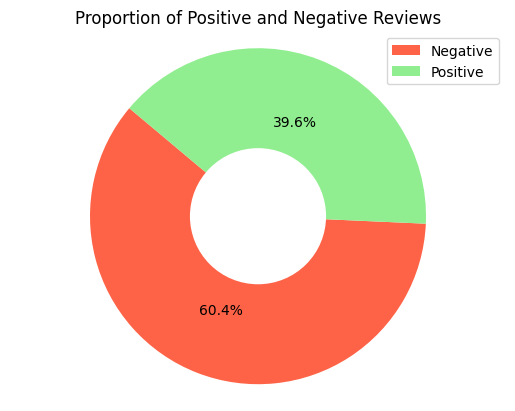

In [ ]:
# Count the occurrences of each class
unique, counts = np.unique(predicted_labels, return_counts=True)

# Create the pie chart
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140, colors=['tomato','lightgreen'], labeldistance=None)

centre_circle = plt.Circle((0, 0), 0.4, color='white', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a legend with labels
plt.legend(['Negative', 'Positive'],loc='best')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Proportion of Positive and Negative Reviews')
plt.show()

## **10.2 Evaluation with unseen test data**

In [ ]:
df_test['overall_rating'] = df_test['overall_rating'].apply(lambda x: 1 if x > 3 else 0)

Accuracy: 0.4196666666666667
Classification report:
              precision    recall  f1-score   support

           0       0.34      0.53      0.42      1165
           1       0.54      0.35      0.42      1835

    accuracy                           0.42      3000
   macro avg       0.44      0.44      0.42      3000
weighted avg       0.46      0.42      0.42      3000

Confusion Matrix:
               Predicted Negative  Predicted Positive
True Negative                 618                 547
True Positive                1194                 641


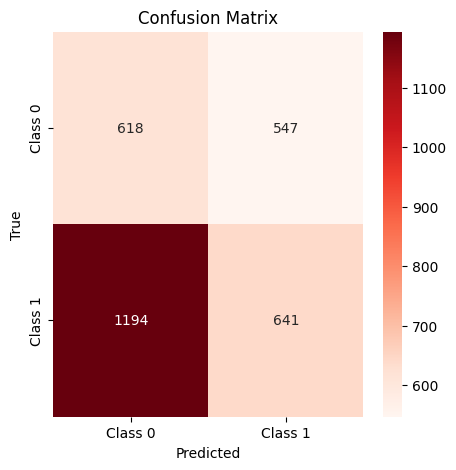

In [ ]:
accuracy = accuracy_score(df_test['overall_rating'], predicted_labels)
report = classification_report(df_test['overall_rating'], predicted_labels)
confusion = confusion_matrix(df_test['overall_rating'], predicted_labels)

#print(f"{model} Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Classification report:")
print(report)
print("Confusion Matrix:")
print(pd.DataFrame(confusion, columns=["Predicted Negative", "Predicted Positive"], index=["True Negative", "True Positive"]))

plt.figure(figsize=(5, 5))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **1.4 Analysis over time**

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Define a function to handle the dropdown selection
def dropdown_handler(change):
    print(change.new)

# Create a dropdown widget
options = ['Annual', 'Monthly', 'Daily']
dropdown = widgets.Dropdown(options=options, description='Period:')

# Display the dropdown widget
dropdown.observe(dropdown_handler, names='value')
display(dropdown)

Dropdown(description='Period:', options=('Annual', 'Monthly', 'Daily'), value='Annual')

In [ ]:
# Map predicted labels to 'Negative' if label is 0, else 'Positive'
predicted_labels_mapped = ['Negative' if label == 0 else 'Positive' for label in predicted_labels]
print(dropdown.value)

# Set default time format
selectedType = '%Y';

# Check the value of 'dropdown' and modify time format accordingly
if dropdown.value == 'Monthly':
  selectedType = '%Y-%m'
elif dropdown.value == 'Daily':
  selectedType = '%Y-%m-%d'

# Create a DataFrame ('df_pred_time') with 'Timestamp' and 'Predictions' columns based on 'df_test' data
df_pred_time = pd.DataFrame({
  'Timestamp': df_test['date_review'].dt.strftime(selectedType).tolist(),
  'Predictions': predicted_labels_mapped
})

print(df_pred_time.sort_values('Timestamp'))

Annual
     Timestamp Predictions
1691      2008    Positive
1337      2008    Positive
1617      2008    Negative
2462      2008    Positive
1904      2008    Negative
...        ...         ...
2476      2021    Negative
1221      2021    Positive
1218      2021    Negative
2448      2021    Negative
1052      2021    Positive

[3000 rows x 2 columns]


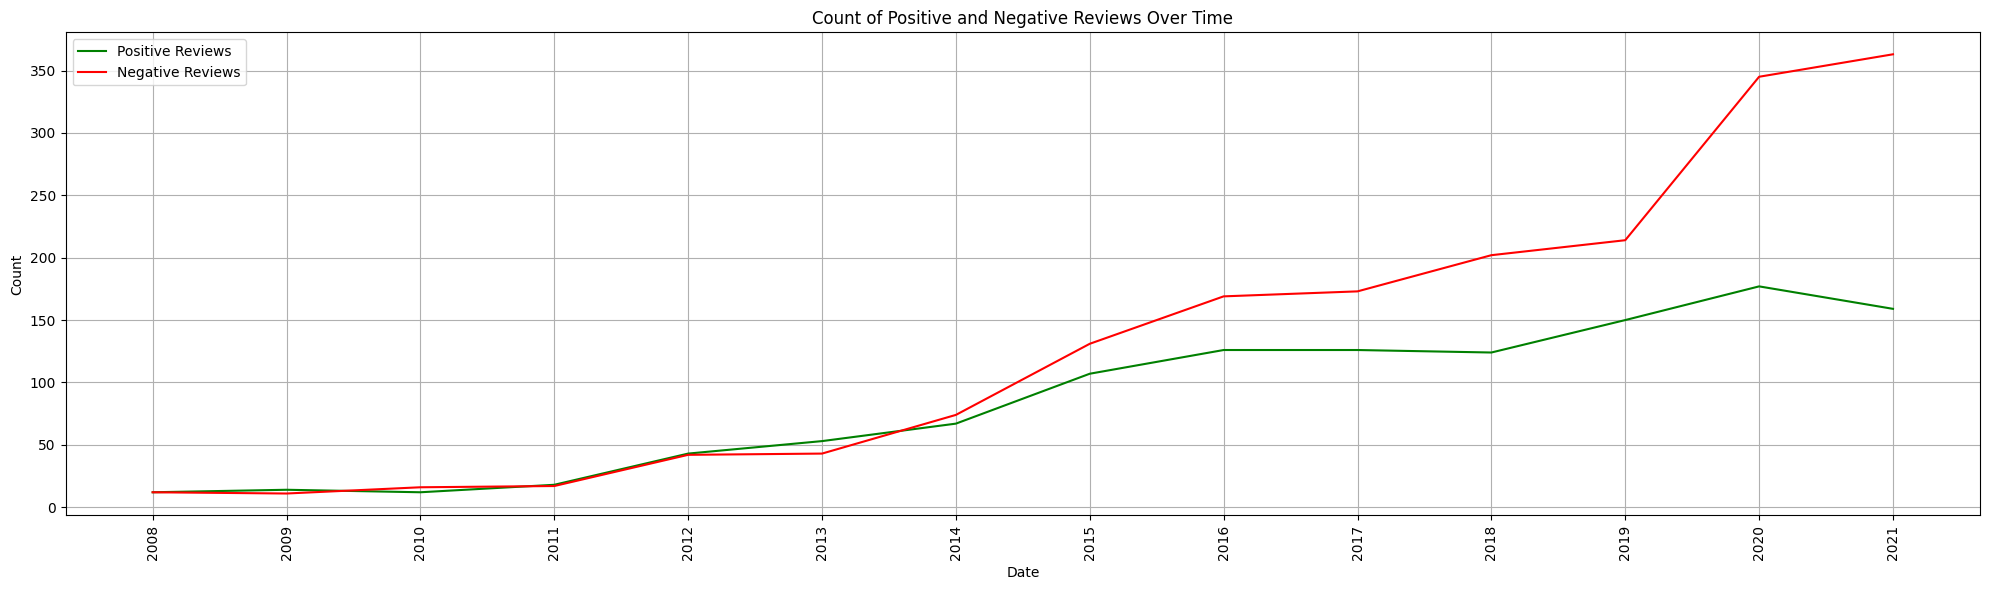

In [ ]:
# Sort the DataFrame by 'Timestamp'
df_sorted = df_pred_time.sort_values('Timestamp')

# Count occurrences of 0s (Negative) and 1s (Positive) for each date
count_data = df_sorted.groupby(['Timestamp', 'Predictions']).size().unstack(fill_value=0)

# Create a line chart
plt.figure(figsize=(20, 6))

# Plot the count of positive (1) reviews as a green line
plt.plot(count_data.index, count_data['Positive'], 'g-', label='Positive Reviews')

# Plot the count of negative (0) reviews as a red line
plt.plot(count_data.index, count_data['Negative'], 'r-', label='Negative Reviews')

# Customize the plot
plt.title('Count of Positive and Negative Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Show the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



---



# **Topic Modelling**

Topic modeling techniques like LDA require a document-term matrix. This can be created using the matrix using CountVectorizer, which converts the text data into a numerical format that LDA can work with.

LDA can only use raw term counts because it is a probabilistic graphical model.

## **1.2 Apply Latent Dirichlet Allocation (LDA)**

In [ ]:
# Initialize the CountVectorizer for LDA
tf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
dtm_lda = tf_vectorizer_lda.fit_transform(df_test['Review'].tolist())
tf_feature_names_lda = tf_vectorizer_lda.get_feature_names_out()

# Apply LDA for topic modeling
num_topics_lda = 10
lda = LatentDirichletAllocation(n_components=num_topics_lda, random_state=42)
lda.fit(dtm_lda)

LatentDirichletAllocation(random_state=42)

In [ ]:
# Get topics and top words for LDA
lda_top_words = []
no_top_words = 3

# Loop through each topic generated by LDA and extract top words
for topic_idx, topic in enumerate(lda.components_):
    top_feature_names = [tf_feature_names_lda[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    lda_top_words.append(top_feature_names)

## **1.3 Non-Negative Matrix Factorization (NMF)**

In [ ]:
# Initialize the TF-IDF Vectorizer for NMF
tfidf_vectorizer_nmf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix_nmf = tfidf_vectorizer_nmf.fit_transform(df_test['Review'].tolist())
tfidf_feature_names_nmf = tfidf_vectorizer_nmf.get_feature_names_out()

# Apply NMF for topic modeling
num_topics_nmf = 15
nmf = NMF(n_components=num_topics_nmf, random_state=42)
nmf.fit(tfidf_matrix_nmf)

NMF(n_components=15, random_state=42)

In [ ]:
# Get topics and top words for NMF
nmf_top_words = []

for topic_idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[-no_top_words:][::-1]
    top_words = [tfidf_feature_names_nmf[i] for i in top_words_idx]
    nmf_top_words.append(top_words)

## **1.3 Extract the topics and associated words**

In [ ]:
# Create a DataFrame to store LDA and NMF topics
# topic_data = {'Topic': list(range(1, num_topics_lda + 1)),
#               'LDA Result': [" | ".join(words) for words in lda_top_words],
#               'NMF Result': [" | ".join(words) for words in nmf_top_words]}
topic_data = {'Topic ID': list(range(1, num_topics_nmf + 1)),
              'NMF Result': [" ".join(words) for words in nmf_top_words]}
topics_df = pd.DataFrame(topic_data)

# Set 'Topic ID' as index
topics_df.set_index('Topic ID', inplace=True)

# Display the DataFrame
print(topics_df)

                            NMF Result
Topic ID                              
1                        good cons bad
2                   great culture team
3                    life balance work
4                     company work big
5                      place work best
6                management staff poor
7                     nice office team
8          opportunities career growth
9                  hours long flexible
10        working environment flexible
11                        job time lot
12                    salary low bonus
13                      pay low decent
14                    people smart lot
15        benefits health compensation


Obtained a list of topics with associated keywords.

To visualize the topics and their prevalence,a bar chart can be used to display the topic percentages. Need to calculate these percentages separately based on the number of documents or words associated with each topic.

### **Bar Plot of Topic Prevalence:**

This code snippet calculates the average topic probabilities across all documents obtained from Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF) models

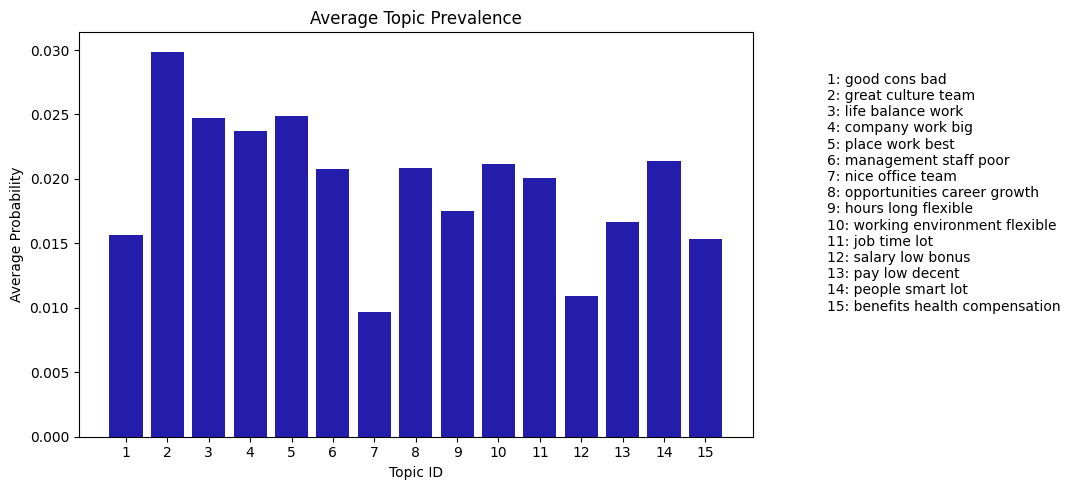

In [ ]:
lda_topic_probabilities = lda.transform(dtm_lda)
nmf_topic_probabilities = nmf.transform(tfidf_matrix_nmf)

# Calculate the average topic probabilities across all documents for both LDA and NMF
lda_avg_probabilities = lda_topic_probabilities.mean(axis=0)
nmf_avg_probabilities = nmf_topic_probabilities.mean(axis=0)

# Plotting bar plots for LDA and NMF topic prevalence
plt.figure(figsize=(11,5))

topic_list = topics_df['NMF Result'].to_list()
legend_text = '\n'.join([f"{i + 1}: {desc}" for i, desc in enumerate(topic_list)])
# plt.subplot(1, 2, 1)
# plt.bar(range(len(lda_avg_probabilities)), lda_avg_probabilities, color='skyblue')
# plt.xlabel('LDA Topics')
# plt.ylabel('Average Probability')
# plt.title('Average Topic Prevalence - LDA')

plt.bar(range(1, len(nmf_avg_probabilities) + 1), nmf_avg_probabilities[:15], color='#241dab')
# Adding textual descriptions near the bars

plt.text(1.11, 0.9, legend_text, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10)

plt.xlabel('Topic ID')
plt.ylabel('Average Probability')
plt.title('Average Topic Prevalence')
plt.xticks(range(1, 16, 1))
plt.tight_layout()
plt.show()

### **Heatmap of Topic Prevalence:**

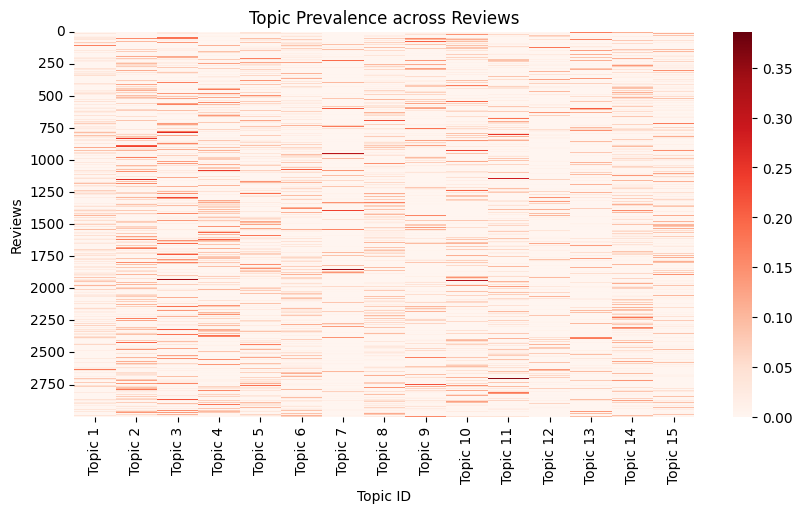

In [ ]:
# Concatenate LDA and NMF topic probabilities for heatmap visualization
# combined_topics = np.concatenate((lda_topic_probabilities, nmf_topic_probabilities), axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 5))
# sns.heatmap(combined_topics, cmap='YlGnBu', xticklabels=['LDA Topic {}'.format(i) for i in range(1, num_topics_lda + 1)] +
#             ['NMF Topic {}'.format(i) for i in range(1, num_topics_nmf + 1)])
sns.heatmap(nmf_topic_probabilities, cmap='Reds', yticklabels=250, xticklabels=['Topic {}'.format(i) for i in range(1, num_topics_nmf + 1)])
plt.xlabel('Topic ID')
plt.ylabel('Reviews')
plt.title('Topic Prevalence across Reviews')
plt.show()

## **1.5 Word clouds**

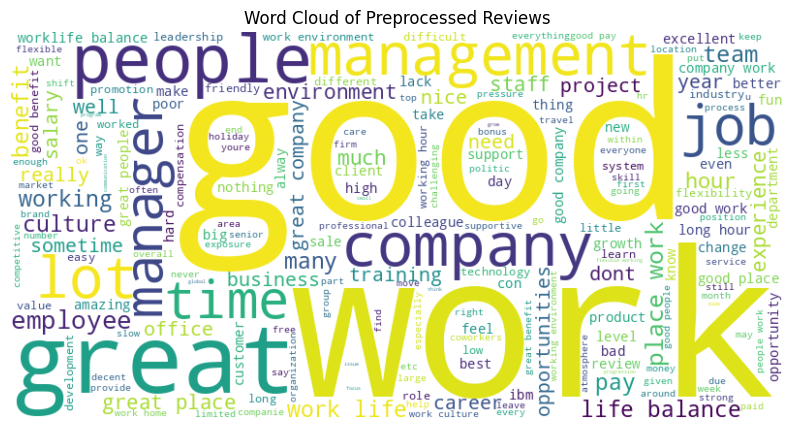

In [ ]:
# Assuming 'reviews_list' contains preprocessed reviews
reviews_text = ' '.join(reviews_list)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Reviews')
plt.show()

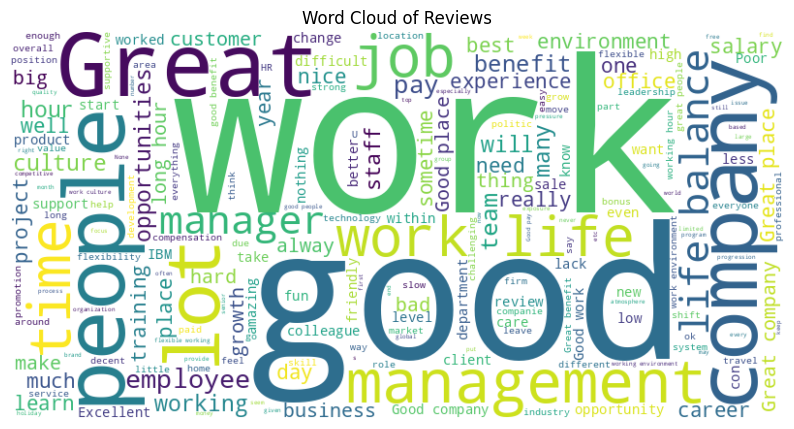

In [ ]:
# Using the raw data the Review column of df_test dataframe
reviews_text = ' '.join(df_test['Review'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()



---



# **Aspect-Based Sentiment Analysis**

## **1.1 Aspect Identification**

To identify relevant aspects in reviews, Named Entity Recognition (NER) or Part-Of-Speech (POS) tagging can be used.

In [ ]:
reviews_list = df_test['Review'].tolist()

In [ ]:
reviews_list

## **1.3 Named-Entity-Recognition (NER) tagging to identify relevant aspects**

In [ ]:
# Load a spaCy model
nlp = spacy.load("en_core_web_sm")

# Get the entity labels and their meanings
labels = {ent: spacy.explain(ent) for ent in nlp.get_pipe("ner").labels}

# Print the labels and their descriptions
for label, description in labels.items():
    print(f"Label: {label}, Description: {description}")


Label: CARDINAL, Description: Numerals that do not fall under another type
Label: DATE, Description: Absolute or relative dates or periods
Label: EVENT, Description: Named hurricanes, battles, wars, sports events, etc.
Label: FAC, Description: Buildings, airports, highways, bridges, etc.
Label: GPE, Description: Countries, cities, states
Label: LANGUAGE, Description: Any named language
Label: LAW, Description: Named documents made into laws.
Label: LOC, Description: Non-GPE locations, mountain ranges, bodies of water
Label: MONEY, Description: Monetary values, including unit
Label: NORP, Description: Nationalities or religious or political groups
Label: ORDINAL, Description: "first", "second", etc.
Label: ORG, Description: Companies, agencies, institutions, etc.
Label: PERCENT, Description: Percentage, including "%"
Label: PERSON, Description: People, including fictional
Label: PRODUCT, Description: Objects, vehicles, foods, etc. (not services)
Label: QUANTITY, Description: Measurement

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Process each review in the list
for review in reviews_list:
    # Process the review with spaCy
    doc = nlp(review)

    # Iterate through the entities and print them for each review
    print(f"Entities in the review: '{review}'")
    for ent in doc.ents:
        print(f"Entity: {ent.text}, Label: {ent.label_}")
    print()

In [ ]:
# Process a batch of sentences
batch_of_sentences = reviews_list

# Initialize counters for entity labels
label_counter = Counter()
person_entities = []
org_entities =[]
date_entities =[]

# Process each sentence in the batch
for sentence in batch_of_sentences:
    doc = nlp(sentence)
    for ent in doc.ents:
        label_counter[ent.label_] += 1
        if (ent.label_ == "PERSON"):
          person_entities.append(ent.text)
        elif (ent.label_ == "ORG"):
          org_entities.append(ent.text)
        elif (ent.label_ == "DATE"):
          date_entities.append(ent.text)
print(date_entities)

['4 years ago', 'Annual', 'every 1 year', 'this over 3 years ago', 'years', 'all day every day', '2 years', '2020', 'annual', 'the first year', 'every week', 'most days', 'Yearly', 'recent years', 'all year', 'each month', 'several years', 'the normal work day', 'Some days', 'weekend', '6-10 years', '6 month', 'a month', 'annual', 'three days', 'about my day to day', 'under 18', 'daily', 'daily', 'Hays', '50-60+ hours', 'days', 'the last 4 years', 'the last 4 years', 'every six months', '7-4', '9-6', '10-7', 'Salary', 'vacation days', 'Monday', 'Friday', 'a day to day', 'two years', 'july 2017', 'the last two years', 'the next 6-9 months', '2013', '2013', 'days', 'between Christmas and New Year', 'vacation days', 'about 1 year', 'yearly', '5 weeks', 'the last two years', 'Monday', 'the years', '6 month', 'this year', 'just over 2 years', 'week to week', 'Monthly', 'month to month', 'year end', '13 month', 'around 9 months a year', 'Yearly', 'the next 1-2 years', '2 years', 'month of Ap

In [ ]:
len(person_entities)

497

In [ ]:
len(set(person_entities))

380

In [ ]:
org_entities

['Nice Nice',
 'agile technology\r\nFusion',
 'KPMG',
 'the Senior Management Team',
 'REED',
 'Bank Holidays',
 'Limited',
 'DIY',
 'SAP',
 'Cybersecurity',
 'Healthcare',
 'IFS',
 'Working',
 'UK Government',
 'Free Food\r\nFree',
 'CS Executive',
 'Morgan Stanley',
 'Morgan',
 'DB Review',
 'Associate Technology Work',
 'Cashier Consistent',
 'Global Company',
 'PTO &',
 'Frequent Traveler',
 'EY',
 'Beware Big',
 'Value',
 'Underpaid',
 'Incompetent Senior Managers & Directors Relaxed',
 'OT',
 'Amazing Culture & Benefits - Company',
 'Budget',
 'LOL',
 'Dreamforce',
 'Software',
 'IBM',
 'the Apple Store',
 'Apple Store',
 'HSA',
 'amex card',
 'Middle Management',
 'IBM',
 'WFH',
 'IBM',
 'IBM',
 'IBM',
 'IBM',
 'Customer Service Team',
 'Good Management',
 'Nice Nice',
 'Nice Company',
 'SAP',
 'Microsoft',
 'SAP',
 'Deloitte',
 'Working for Vodafone Flexibility',
 'Customer',
 'IBM',
 'AVP',
 'Internal Politics - Need',
 'C& W',
 'Wyclef',
 'SD',
 'State',
 'Nurses',
 'Personal

In [ ]:
len(org_entities)

1343

In [ ]:
len(set(org_entities))

899

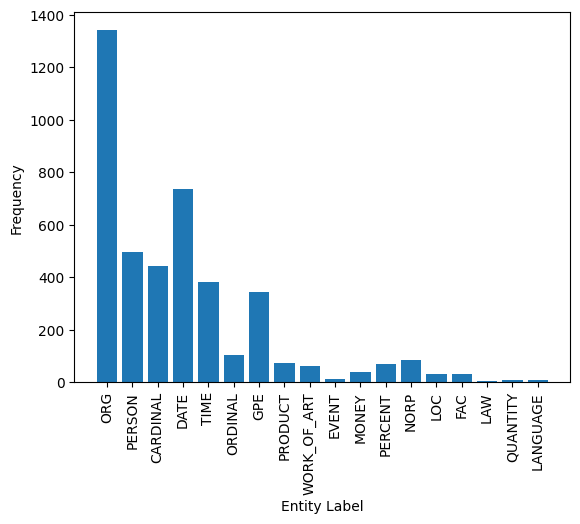

In [ ]:
# Create a bar chart to visualize the frequency of each entity labels
labels, counts = zip(*label_counter.items())
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.xlabel("Entity Label")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from collections import defaultdict
from tabulate import tabulate
from IPython.display import display, HTML

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Load a spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Sample dataset of sentences with entities
dataset = person_entities

# Create a dictionary to store sentiment for each entity
entity_sentiment = defaultdict(list)

# Process each sentence in the dataset
for sentence in dataset:
    # Perform sentiment analysis on the sentence
    sentiment = analyzer.polarity_scores(sentence)

    # Process the sentence with spaCy to extract NER
    doc = nlp(sentence)

    # Extract named entities and assign sentiment to each entity
    for ent in doc.ents:
        entity_sentiment[ent.text].append(sentiment)

# Count the positive and negative sentiments for each entity
entity_sentiment_counts = {}
for entity, sentiments in entity_sentiment.items():
    positive_count = sum(1 for sentiment in sentiments if sentiment["compound"] > 0)
    negative_count = sum(1 for sentiment in sentiments if sentiment["compound"] < 0)
    entity_sentiment_counts[entity] = {"positive": positive_count, "negative": negative_count}

# Visualize the sentiment counts for each entity
entities = list(entity_sentiment_counts.keys())
positive_counts = [entity_sentiment_counts[entity]["positive"] for entity in entities]
negative_counts = [entity_sentiment_counts[entity]["negative"] for entity in entities]

# Filter out entities with non-neutral sentiment counts
filtered_entities = [
    entity for entity, counts in entity_sentiment_counts.items() if counts["positive"] + counts["negative"] > 0
]

# Determine colors based on sentiment
colors = ["Green" if entity_sentiment_counts[entity]["positive"] > entity_sentiment_counts[entity]["negative"] else "Red"
          for entity in filtered_entities]

# Create HTML content for the table with color boxes
html_content = "<html><head><style>table {font-family: Arial, sans-serif; border-collapse: collapse;}"
html_content += "td, th {border: 1px solid #dddddd; text-align: left; padding: 8px;}"
html_content += ".red-box {background-color: #ff9999; width: 20px; height: 20px; display: inline-block;}"
html_content += ".green-box {background-color: #99ff99; width: 20px; height: 20px; display: inline-block;}"
html_content += "</style></head><body>"
html_content += "<table><tr><th>Entities</th><th>Sentiment</th></tr>"

# Generate table rows with entities and colored boxes representing sentiment
for entity, color in zip(filtered_entities, colors):
    sentiment_color_box = '<td class="red-box"></td>' if color == "Red" else '<td class="green-box"></td>'
    html_content += f"<tr><td>{entity}</td>{sentiment_color_box}</tr>"

html_content += "</table></body></html>"

# Display the HTML content in the notebook
display(HTML(html_content))

# Save the HTML content to a file
with open("sentiment_table.html", "w") as file:
    file.write(html_content)

# Display the path to the generated HTML file
print("HTML file generated with sentiment color boxes: sentiment_table.html")


Entities,Sentiment
Cashier Easy,
Best Employer,
Paid Holidays,
Cleaner Cool,
Great Strong,
Recruiter Great,
Arnold Clark Good,
Auditor Good,
Assurance Learning,
JPMorgan Thankfully,


HTML file generated with sentiment color boxes: sentiment_table.html


In [ ]:
from collections import defaultdict
from tabulate import tabulate
from IPython.display import display, HTML

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Load a spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Sample dataset of sentences with entities
dataset = org_entities

# Create a dictionary to store sentiment for each entity
entity_sentiment = defaultdict(list)

# Process each sentence in the dataset
for sentence in dataset:
    # Perform sentiment analysis on the sentence
    sentiment = analyzer.polarity_scores(sentence)

    # Process the sentence with spaCy to extract NER
    doc = nlp(sentence)

    # Extract named entities and assign sentiment to each entity
    for ent in doc.ents:
        entity_sentiment[ent.text].append(sentiment)

# Count the positive and negative sentiments for each entity
entity_sentiment_counts = {}
for entity, sentiments in entity_sentiment.items():
    positive_count = sum(1 for sentiment in sentiments if sentiment["compound"] > 0)
    negative_count = sum(1 for sentiment in sentiments if sentiment["compound"] < 0)
    entity_sentiment_counts[entity] = {"positive": positive_count, "negative": negative_count}

# Visualize the sentiment counts for each entity
entities = list(entity_sentiment_counts.keys())
positive_counts = [entity_sentiment_counts[entity]["positive"] for entity in entities]
negative_counts = [entity_sentiment_counts[entity]["negative"] for entity in entities]

# Filter out entities with non-neutral sentiment counts
filtered_entities = [
    entity for entity, counts in entity_sentiment_counts.items() if counts["positive"] + counts["negative"] > 0
]

# Determine colors based on sentiment
colors = ["Green" if entity_sentiment_counts[entity]["positive"] > entity_sentiment_counts[entity]["negative"] else "Red"
          for entity in filtered_entities]

# Create HTML content for the table with color boxes
html_content = "<html><head><style>table {font-family: Arial, sans-serif; border-collapse: collapse;}"
html_content += "td, th {border: 1px solid #dddddd; text-align: left; padding: 8px;}"
html_content += ".red-box {background-color: #ff9999; width: 20px; height: 20px; display: inline-block;}"
html_content += ".green-box {background-color: #99ff99; width: 20px; height: 20px; display: inline-block;}"
html_content += "</style></head><body>"
html_content += "<table><tr><th>Entities</th><th>Sentiment</th></tr>"

# Generate table rows with entities and colored boxes representing sentiment
for entity, color in zip(filtered_entities, colors):
    sentiment_color_box = '<td class="red-box"></td>' if color == "Red" else '<td class="green-box"></td>'
    html_content += f"<tr><td>{entity}</td>{sentiment_color_box}</tr>"

html_content += "</table></body></html>"

# Display the HTML content in the notebook
display(HTML(html_content))

# Save the HTML content to a file
with open("sentiment_table.html", "w") as file:
    file.write(html_content)

# Display the path to the generated HTML file
print("HTML file generated with sentiment color boxes: sentiment_table.html")

Entities,Sentiment
KPMG,
Bank Holidays,
Free Food Free,
Incompetent Senior Managers & Directors Relaxed,
Amazing Culture & Benefits - Company,
LOL,
IBM,
Microsoft,
Working for Vodafone Flexibility,
Microsoft Data Scientist Review Great,


HTML file generated with sentiment color boxes: sentiment_table.html
